In [40]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_svmlight_file
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
X_train, y_train = load_svmlight_file('a9a.txt')
X_test, y_test = load_svmlight_file('a9a.t')

In [4]:
#-------------------SOME HELPER FUNCTION--------------------------

def cross_val_acc(model, tx, ty):
    accs = cross_val_score(model, tx, ty, cv=3)
    return sum(accs)/3

In [47]:
#-------------------RANDOM FOREST CLASSIFIER----------------------

rfc_original = RandomForestClassifier()

rfc_original_cv = sum(cross_val_score(rfc_original, X_train, y_train, cv=5))/5
print(f'Cross validation accuracy: {round(rfc_original_cv*100, 2)}%')

rfc_original.fit(X_train, y_train)
rfc_pred_original = [round(p) for p in rfc_original.predict(X_test)]
rfc_acc_original = accuracy_score(y_test, rfc_pred_original)
print(f'Original Accuracy: {round(rfc_acc_original*100, 2)}%')

Cross validation accuracy: 83.11%
Original Accuracy: 83.37%


In [8]:
#looking at bootstrapping

rfc = RandomForestClassifier(bootstrap=False)
acc1 = cross_val_acc(rfc, X_train, y_train)
rfc = RandomForestClassifier(bootstrap=True)
acc2 = cross_val_acc(rfc, X_train, y_train)
print(f'Accuracy w/out bootstrapping: {round(acc1*100, 2)}% \nAccuracy w/ bootstrapping: {round(acc2*100, 2)}%')

Accuracy w/out bootstrapping: 82.75% 
Accuracy w/ bootstrapping: 83.14%


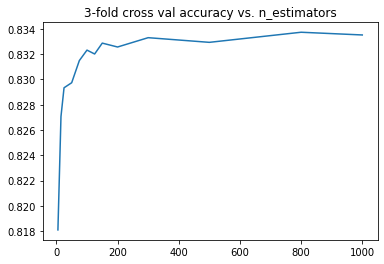

In [9]:
#looking at n_estimators

nrange = [5, 15, 25, 50, 75, 100, 125, 150, 200, 300, 500, 800, 1000]
accs = []

for n in nrange:
    rfc = RandomForestClassifier(n_estimators=n)
    acc = cross_val_acc(rfc, X_train, y_train)
    accs.append(acc)

plt.title("3-fold cross val accuracy vs. n_estimators")
plt.plot(nrange, accs)
plt.show()

In [10]:
'''
It seems that the number of estimators being higher is more preferable, but past ~300, there is no marginal benefit to
increasing the number. So, when applying GridSearchCV, the range of concern will go no further than 400.
'''

'\nIt seems that the number of estimators being higher is more preferable, but past ~300, there is no marginal benefit to\nincreasing the number. So, when applying GridSearchCV, the range of concern will go no further than 400.\n'

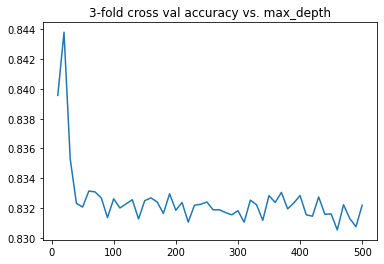

In [11]:
#looking at max_depth

drange = [i*10 for i in range(1, 31)]
accs = []

for d in drange:
    rfc = RandomForestClassifier(max_depth=d)
    acc = cross_val_acc(rfc, X_train, y_train)
    accs.append(acc)
    
plt.title("3-fold cross val accuracy vs. max_depth")
plt.plot(drange, accs)
plt.show()

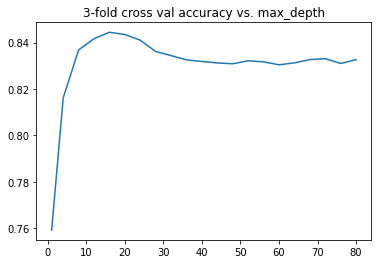

In [12]:
#trying a range towards lower values (max_depth)
drange = [1] + [i*4 for i in range(1, 21)]
accs = []

for d in drange:
    rfc = RandomForestClassifier(max_depth=d)
    acc = cross_val_acc(rfc, X_train, y_train)
    accs.append(acc)
    
plt.title("3-fold cross val accuracy vs. max_depth")
plt.plot(drange, accs)
plt.show()

In [13]:
'''
It seems that a max depth of around 15 is the best on its own, whereas increasing the depth further results
in a reduction in accuracy, and it stays about the same after that. So, when using GridSearchCV, I will only consider a range
up to 50.
'''

'\nIt seems that a max depth of around 15 is the best on its own, whereas increasing the depth further results\nin a reduction in accuracy, and it stays about the same after that. So, when using GridSearchCV, I will only consider a range\nup to 50.\n'

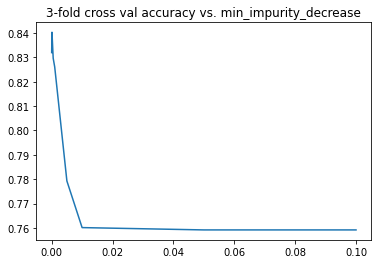

In [14]:
#looking at min_impurity_decrease

midrange = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
accs = []

for mid in midrange:
    rfc = RandomForestClassifier(min_impurity_decrease=mid)
    acc = cross_val_acc(rfc, X_train, y_train)
    accs.append(acc)
    
plt.title('3-fold cross val accuracy vs. min_impurity_decrease')
plt.plot(midrange, accs)
plt.show()

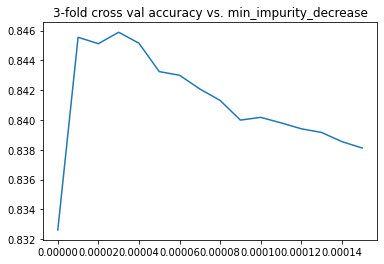

In [15]:
#Using a more specific range towards smaller values (min_impurity_decrease)

midrange = [0] + [0.00001 + i*0.00001 for i in range(15)]
accs = []

for mid in midrange:
    rfc = RandomForestClassifier(min_impurity_decrease=mid)
    acc = cross_val_acc(rfc, X_train, y_train)
    accs.append(acc)
    
plt.title('3-fold cross val accuracy vs. min_impurity_decrease')
plt.plot(midrange, accs)
plt.show()

In [16]:
'''
It seems like the min info gain is best at 0.00005 when all other parameters are at default. The accuracy after this decreases
pretty steep. For GridSearchCV, I will only consider a range from 0 to 0.0002.
'''

'\nIt seems like the min info gain is best at 0.00005 when all other parameters are at default. The accuracy after this decreases\npretty steep. For GridSearchCV, I will only consider a range from 0 to 0.0002.\n'

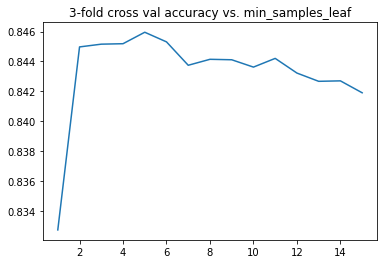

In [17]:
#looking at min_samples_leaf

mslrange = [i for i in range(1, 16)]
accs = []

for msl in mslrange:
    rfc = RandomForestClassifier(min_samples_leaf=msl)
    acc = cross_val_acc(rfc, X_train, y_train)
    accs.append(acc)
    
plt.title('3-fold cross val accuracy vs. min_samples_leaf')
plt.plot(mslrange, accs)
plt.show()

In [18]:
'''
On its own, min_samples_leaf seems to produce the best results at 6. However, hyperparameters like max_depth,
min_impurity_decrease, and min_samples_leaf produce similar effects on the complexity of the model, so I will consider a
more robust range going up to 20 in increments by 2.
'''

'\nOn its own, min_samples_leaf seems to produce the best results at 6. However, hyperparameters like max_depth,\nmin_impurity_decrease, and min_samples_leaf produce similar effects on the complexity of the model, so I will consider a\nmore robust range going up to 20 in increments by 2.\n'

In [19]:
#Using the plots to see the importance of hyperparameters

'''
From the plots, it can be seen that max_depth and n_estimators most significantly affects the accuracy because they result
in the largest change. The third most important hyperparameter is min_samples_leaf and then min_impurity_decrease.
'''

'\nFrom the plots, it can be seen that max_depth and n_estimators most significantly affects the accuracy because they result\nin the largest change. The third most important hyperparameter is min_samples_leaf and then min_impurity_decrease.\n'

In [20]:
#Using GridSearchCV to find best combination of max_depth and n_estimators
rfc_1 = RandomForestClassifier()

params = {
    'n_estimators': [10, 30, 50, 75, 100, 150, 200],
    'max_depth': [1, 2, 5, 10, 15, 20, 25, 30],
}

rfc_gs1 = GridSearchCV(rfc, params)
rfc_gs1.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(min_samples_leaf=15),
             param_grid={'max_depth': [1, 2, 5, 10, 15, 20, 25, 30],
                         'n_estimators': [10, 30, 50, 75, 100, 150, 200]})

In [21]:
#getting the best performing combination of parameters
rfc_max_depth_tuned = rfc_gs1.best_params_['max_depth']
rfc_n_estimators_tuned = rfc_gs1.best_params_['n_estimators']

print(f'Best params: {rfc_gs1.best_params_}')
print(f'Accuracy: {round(rfc_gs1.best_score_ * 100, 2)}%')

Best params: {'max_depth': 25, 'n_estimators': 30}
Accuracy: 84.3%


In [10]:
#Conducting GridSearchCV on the same hyperparameters but using a more fine tuned range
#I reran this a couple of times and played around with the range, so the final one is the range that works best.

params = {
    'n_estimators': [25, 30, 33, 35],
    'max_depth': [14, 16, 18, 20, 22]
}

rfc_11 = RandomForestClassifier()
rfc_gs11 = GridSearchCV(rfc_11, params)
rfc_gs11.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [14, 16, 18, 20, 22],
                         'n_estimators': [25, 30, 33, 35]})

In [13]:
print(f'Best params: {rfc_gs11.best_params_}')
print(f'Accuracy: {round(rfc_gs11.best_score_ * 100, 2)}%')

Best params: {'max_depth': 18, 'n_estimators': 33}
Accuracy: 84.43%


In [14]:
#this got a slighly better score! Now, it can be time to tune the less influential hyperparameters.

rfc_max_depth_tuned, rfc_n_estimators_tuned = rfc_gs11.best_params_['max_depth'], rfc_gs11.best_params_['n_estimators']

In [20]:
#Using GridSearchCV to find the best combination of min_impurity_decrease and min_samples_leaf given the previously tuned
#parameters

rfc_2 = RandomForestClassifier(
    n_estimators = rfc_n_estimators_tuned,
    max_depth = rfc_max_depth_tuned
)

params = {
    'min_impurity_decrease': [0.0, 0.00001, 0.00002],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

rfc_gs2 = GridSearchCV(rfc_2, params)
rfc_gs2.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=18, n_estimators=33),
             param_grid={'min_impurity_decrease': [0.0, 1e-05, 2e-05],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10]})

In [21]:
rfc_mid_tuned = rfc_gs2.best_params_['min_impurity_decrease']
rfc_msl_tuned = rfc_gs2.best_params_['min_samples_leaf']

print(f'Best params: {rfc_gs2.best_params_}')
print(f'Accuracy: {round(rfc_gs2.best_score_ * 100, 2)}%')

Best params: {'min_impurity_decrease': 0.0, 'min_samples_leaf': 2}
Accuracy: 84.42%


In [18]:
#Testing for any accuracy changes when applying bootstrapping

bootstraps = [False, True]
for b in bootstraps:
    rfc_3 = RandomForestClassifier(
        n_estimators = 33,
        max_depth = 18,
        min_impurity_decrease = 0.0,
        min_samples_leaf = 2,
        bootstrap=b
    )
    acc = sum(cross_val_score(rfc_3, X_train, y_train, cv=5))/5
    print(f'tuned rfc (bs = {b}): {round(acc*100, 2)}%')

tuned rfc (bs = False): 84.45%
tuned rfc (bs = True): 84.53%


In [36]:
#attempting to retune some parameters using RandomizedSearchCV

params = {
    'min_impurity_decrease': uniform(0.0, 0.01),
    'min_samples_leaf': randint(1, 5)
}

rfc_rs1 = RandomForestClassifier(
    n_estimators = 33,
    max_depth = 18,
    bootstrap=True
)
rs1 = RandomizedSearchCV(rfc_rs1, params, n_iter=10)
rs1.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(max_depth=18,
                                                    n_estimators=33),
                   param_distributions={'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C58C37FBB0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C58C39D9F0>})

In [33]:
rs1.cv_results_

{'mean_fit_time': array([0.19179196, 0.12259922, 0.12557869, 0.17375064, 0.15217357,
        0.11225967, 0.15709758, 0.11586347, 0.10754972, 0.17393227]),
 'std_fit_time': array([0.00709598, 0.00922399, 0.0132963 , 0.02211554, 0.00645306,
        0.0018328 , 0.00795697, 0.00422715, 0.00524739, 0.00736107]),
 'mean_score_time': array([0.01366839, 0.01234822, 0.0122025 , 0.01479745, 0.01260328,
        0.01140165, 0.01240449, 0.01140542, 0.01120038, 0.01300426]),
 'std_score_time': array([0.0017264 , 0.00042732, 0.00074504, 0.00222461, 0.00080168,
        0.00049076, 0.0004885 , 0.00049364, 0.00039616, 0.00063377]),
 'param_min_impurity_decrease': masked_array(data=[0.005207159802958861, 0.036392770084817,
                    0.023927366306897138, 0.0046271866936269945,
                    0.0071674967510723725, 0.02098107003212258,
                    0.004611072336731653, 0.020165364039299433,
                    0.046919877655203585, 0.003137394006022959],
              mask=[False, F

In [37]:
rs1.best_params_

{'min_impurity_decrease': 0.0013374093386498598, 'min_samples_leaf': 2}

In [38]:
rs1.best_score_

0.8231321518746668

In [45]:
#changing min_samples_leaf by itself

for m in range(1, 6):
    rfc = RandomForestClassifier(
        n_estimators = 33,
        max_depth = 18,
        min_impurity_decrease = 0.0,
        min_samples_leaf = m,
        bootstrap=True
    )
    acc = sum(cross_val_score(rfc, X_train, y_train, cv=5))/5
    print(m, round(acc*100, 2))

1 84.29
2 84.45
3 84.39
4 84.32
5 84.37


In [51]:
#Implementing the tuned Random Forest Classifier and testing

rfc_tuned = RandomForestClassifier(
    n_estimators = 33,
    max_depth = 18,
    min_impurity_decrease = 0.0,
    min_samples_leaf = 2,
    bootstrap = True
)

rfc_tuned_cv_acc = sum(cross_val_score(rfc_tuned, X_train, y_train, cv=5))/5

print(f'Cross val accuracy from tuned RFC: {round(rfc_tuned_cv_acc*100, 2)}%')

rfc_tuned.fit(X_train, y_train)
rfc_pred_tuned = [round(p) for p in rfc_tuned.predict(X_test)]
rfc_acc_tuned = accuracy_score(y_test, rfc_pred_tuned)
print(f'Test accuracy from tuned RFC: {round(rfc_acc_tuned * 100, 2)}%')
print(f'An improvement of {round((rfc_acc_tuned - rfc_acc_original)*100, 2)}%')

Cross val accuracy from tuned RFC: 84.51%
Test accuracy from tuned RFC: 84.74%
An improvement of 1.37%


In [48]:
#Table of most sinificant hyperparameter combos and their cross val accuracy

table_dict = {
    'n_estimators': [100, 25, 33, 33, 33, 33, 33, 33, 33],
    'max_depth': ['None', 30, 18, 18, 18, 18, 18, 18, 18],
    'min_impurity_decrease': [0.0, 0.0, 0.0, 0.0, 0.0, 0.035, 0.00134, 0.0, 0.0],
    'min_samples_leaf': [1, 1, 1, 2, 2, 2, 2, 3, 4],
    'bootstrap': ['False', 'False', 'False', 'False', 'True', 'True', 'True', 'True', 'True'],
    'CV Accuracy': [83.11, 84.3, 84.43, 84.42, 84.53, 75.92, 82.31, 84.39, 84.32]
}

table_rfc = pd.DataFrame.from_dict(table_dict)
display(table_rfc)

,n_estimators,max_depth,min_impurity_decrease,min_samples_leaf,bootstrap,CV Accuracy
0,100,None,0.00000,1,False,83.11
1,25,30,0.00000,1,False,84.30
2,33,18,0.00000,1,False,84.43
3,33,18,0.00000,2,False,84.42
4,33,18,0.00000,2,True,84.53
5,33,18,0.03500,2,True,75.92
6,33,18,0.00134,2,True,82.31
7,33,18,0.00000,3,True,84.39
8,33,18,0.00000,4,True,84.32


In [ ]:
#4)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import numpy as np

y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_train = np.where(y_train==-1, 0, y_train)
y_test = np.where(y_test==-1, 0, y_test)

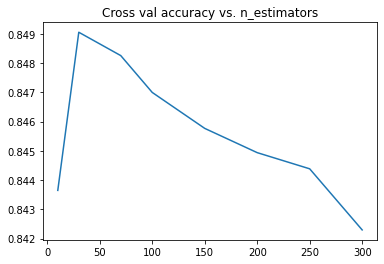

In [59]:
#looking at n_estimators

ne_range = [10, 30, 70, 100, 150, 200, 250, 300]
accs = []

for ne in ne_range:
    gbc = XGBClassifier(n_estimators=ne, use_label_encoder=False, verbosity=0)
    acc = sum(cross_val_score(gbc, X_train, y_train, cv=5))/5
    accs.append(acc)

plt.title('Cross val accuracy vs. n_estimators')
plt.plot(ne_range, accs)
plt.show()

In [53]:
gb_original = XGBClassifier(use_label_encoder=False, verbosity=0)

gbc_original_cv = sum(cross_val_score(gb_original, X_train, y_train, cv=5))/5
print(f'Original cross val Accuracy: {round(gbc_original_cv*100, 2)}%')

gb_original.fit(X_train, y_train)
pred = [round(p) for p in gb_original.predict(X_test)]
gbc_acc_original = accuracy_score(y_test, pred)
print(f'Original accuracy for XGBoost: {round(gbc_acc_original*100, 2)}%')

Original cross val Accuracy: 84.7%
Original accuracy for XGBoost: 84.83%


In [58]:
#n_estimators is very influential when it comes to overfitting. Max depth is also influential, so I will test that too

params ={
    'n_estimators': randint(1, 400),
    'max_depth': randint(2, 10)
}

gbc_1 = XGBClassifier(use_label_encoder=False, verbosity=0)
gbc_rs1 = RandomizedSearchCV(gbc_1, params, n_iter=300)
gbc_rs1.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, 

In [60]:
gbc_rs1.best_params_

{'max_depth': 5, 'n_estimators': 61}

In [61]:
gbc_rs1.best_score_

0.8508339633339634

In [62]:
#Now I am going to find the optimal learning rate at this level. The learning rate and n_estimators have a trade off,
#so I decided to find the best n_estimators, and then find the appropriate learning rate.

params = {
    'learning_rate': [0.05, 0.07, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
}

gbc_2 = XGBClassifier(max_depth=5, n_estimators=61, use_label_encoder=False, verbosity=0)
gbc_gs1 = GridSearchCV(gbc_2, params)
gbc_gs1.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=61, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                

In [63]:
gbc_gs1.best_params_

{'learning_rate': 0.3}

In [64]:
gbc_gs1.best_score_

0.8508339633339634

In [65]:
gbc_gs1.cv_results_

{'mean_fit_time': array([0.18623905, 0.18504128, 0.18284082, 0.18224082, 0.18063989,
        0.18123999, 0.1782403 , 0.17823949, 0.17443895, 0.17343845,
        0.17303843, 0.17103801]),
 'std_fit_time': array([4.95192978e-03, 1.09580107e-03, 1.16650686e-03, 1.72076747e-03,
        1.49643988e-03, 5.07617365e-03, 1.72069523e-03, 4.91660629e-03,
        1.62510668e-03, 1.35675442e-03, 1.67331280e-03, 3.23406696e-07]),
 'mean_score_time': array([0.00420122, 0.0044013 , 0.00440102, 0.00400062, 0.0046011 ,
        0.00460129, 0.00440073, 0.00460114, 0.00420094, 0.00400209,
        0.00460124, 0.0044014 ]),
 'std_score_time': array([3.99804467e-04, 4.90096344e-04, 4.89843034e-04, 6.28991411e-07,
        4.90154472e-04, 4.90115569e-04, 4.89590332e-04, 4.89998722e-04,
        3.99947177e-04, 1.46195504e-06, 4.90076682e-04, 4.90115569e-04]),
 'param_learning_rate': masked_array(data=[0.05, 0.07, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2, 0.25,
                    0.3, 0.35, 0.4],
              mask=[Fa

In [118]:
#Now I will find the best loss/objective function. I only considered binary classificaiton loss functions and no regression
#or multiclassification ones, expecting that they simply wouldn't be applicable.

params = {
    'objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge', 'reg:squarederror', 'reg:squaredlogerror']
}

gbc_3 = XGBClassifier(max_depth=5, n_estimators=61, learning_rate=0.3, use_label_encoder=False, verbosity=0)
gbc_gs2 = GridSearchCV(gbc_3, params)
gbc_gs2.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=61, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                 

In [119]:
gbc_gs2.best_params_

{'objective': 'binary:logistic'}

In [120]:
gbc_gs2.best_score_

0.8508339633339634

In [121]:
gbc_gs2.cv_results_

{'mean_fit_time': array([0.19264259, 0.20524573, 0.17663922, 0.16923752, 0.19204297]),
 'std_fit_time': array([0.0142097 , 0.02777911, 0.00320076, 0.00213587, 0.00167383]),
 'mean_score_time': array([0.00460105, 0.00420117, 0.00440121, 0.00400124, 0.004001  ]),
 'std_score_time': array([4.90115523e-04, 4.00066575e-04, 4.90076589e-04, 6.32711299e-04,
        3.56832255e-07]),
 'param_objective': masked_array(data=['binary:logistic', 'binary:logitraw', 'binary:hinge',
                    'reg:squarederror', 'reg:squaredlogerror'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'objective': 'binary:logistic'},
  {'objective': 'binary:logitraw'},
  {'objective': 'binary:hinge'},
  {'objective': 'reg:squarederror'},
  {'objective': 'reg:squaredlogerror'}],
 'split0_test_score': array([0.84615385, 0.83985874, 0.83924459, 0.84369722, 0.84093352]),
 'split1_test_score': array([0.84781941, 0.83937346, 0.83906634, 0.843366

In [72]:
#Now I am going to test the regularization parameter lambda (starting with values < 1 and > 0)

params = {
    'lambda': uniform(0.01, 1)
}

gbc_4 = XGBClassifier(max_depth=5, n_estimators=61, learning_rate=0.3, objective='binary:logistic', verbosity=0, use_label_encoder=False)
gbc_rs2 = RandomizedSearchCV(gbc_4, params, n_iter=30) 
gbc_rs2.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.3,
                                           max_delta_step=None, max_depth=5,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=61, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_s

In [73]:
gbc_rs2.best_params_

{'lambda': 0.9848675410167865}

In [74]:
gbc_rs2.best_score_

0.8504960924871104

In [75]:
#now with lambda values between 1 and 10

params = {
    'lambda': uniform(1, 9)
}

gbc_5 = XGBClassifier(max_depth=5, n_estimators=61, learning_rate=0.3, objective='binary:logistic')
gbc_rs3 = RandomizedSearchCV(gbc_4, params, n_iter=100) 
gbc_rs3.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.3,
                                           max_delta_step=None, max_depth=5,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=61, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_s

In [76]:
gbc_rs3.best_params_

{'lambda': 9.809332979612485}

In [77]:
#best so far
gbc_rs3.best_score_

0.8510182715272535

In [84]:
#seems like values near the 5-7 range produce good results. I'm going to use a more specific range

params = {
    'lambda': uniform(5, 3)
}

gbc_6 = XGBClassifier(max_depth=5, n_estimators=61, learning_rate=0.3, objective='binary:logistic')
gbc_rs4 = RandomizedSearchCV(gbc_4, params, n_iter=100) 
gbc_rs4.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.3,
                                           max_delta_step=None, max_depth=5,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=61, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_s

In [85]:
gbc_rs4.best_params_

{'lambda': 6.401727501150869}

In [86]:
#now the best lambda
gbc_rs4.best_score_

0.8512024335377628

In [87]:
#seeing if larger lambda offers any better results

params = {
    'lambda': [l for l in range(10, 101)]
}

gbc_7 = XGBClassifier(max_depth=5, n_estimators=61, learning_rate=0.3, objective='binary:logistic', use_label_encoder=False, verbosity=0)
gbc_rs5 = GridSearchCV(gbc_7, params) 
gbc_rs5.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=61, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                 

In [88]:
gbc_rs5.best_params_

{'lambda': 19}

In [89]:
#not as good
gbc_rs5.best_score_

0.8509261150728218

In [ ]:
#lamda = 6.4 still gives best cv score

In [92]:
#now I am going to compare the accuracy with the missing parameter

params = {
    'missing': uniform(0, 1)
}

gbc_8 = XGBClassifier(
    max_depth=5, 
    n_estimators=61, 
    learning_rate=0.3, 
    objective='binary:logistic', 
    reg_lambda=6.4, 
    use_label_encoder=False, 
    verbosity=0
)
gbc_gs3 = RandomizedSearchCV(gbc_8, params, n_iter=30) 
gbc_gs3.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.3,
                                           max_delta_step=None, max_depth=5,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=61, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_s

In [93]:
gbc_gs3.best_params_

{'missing': 0.15371972768770858}

In [94]:
gbc_gs3.best_score_

0.8510181630690612

In [122]:
gbc_gs3.cv_results_

{'mean_fit_time': array([0.17963948, 0.18644137, 0.17903981, 0.17603903, 0.17683897,
        0.17503872, 0.17503929, 0.17943983, 0.17543893, 0.1822403 ,
        0.18304086, 0.17523861, 0.17743959, 0.17763906, 0.17483869,
        0.1754385 , 0.18064003, 0.17543898, 0.17663922, 0.17743864,
        0.17483888, 0.17463889, 0.17523909, 0.17523904, 0.17503905,
        0.1756392 , 0.17503862, 0.17563896, 0.17603903, 0.17783933]),
 'std_fit_time': array([0.00500439, 0.00854864, 0.0037422 , 0.00228077, 0.00240027,
        0.0015497 , 0.00340661, 0.007339  , 0.00215497, 0.00376407,
        0.00769604, 0.00116659, 0.00224532, 0.00300702, 0.002316  ,
        0.00102017, 0.00700451, 0.00294025, 0.00185509, 0.00294073,
        0.00097988, 0.0022455 , 0.00204002, 0.00116635, 0.00363397,
        0.00080051, 0.00282971, 0.00174411, 0.00167365, 0.00515436]),
 'mean_score_time': array([0.00480108, 0.00480123, 0.00400124, 0.00460114, 0.00400143,
        0.00420132, 0.004601  , 0.00440125, 0.004001  , 0.00

In [98]:
#Choosing a more specific range to see if we can get just a bit better

params = {
    'missing': uniform(0.13, 0.07)
}

gbc_81 = XGBClassifier(
    max_depth=5, 
    n_estimators=61, 
    learning_rate=0.3, 
    objective='binary:logistic', 
    reg_lambda=6.4, 
    use_label_encoder=False, 
    verbosity=0
)
gbc_gs31 = RandomizedSearchCV(gbc_81, params, n_iter=70) 
gbc_gs31.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.3,
                                           max_delta_step=None, max_depth=5,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=61, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_s

In [99]:
gbc_gs31.best_params_

{'missing': 0.16681824361603392}

In [100]:
#missing doesn't seem to have any effect on the accuracy of model
gbc_gs31.best_score_

0.8510181630690612

In [ ]:
#seems best to leave the missing as the default value of nothing

In [102]:
#Going back to tune a more specific n_estimator setting

params = {
    'n_estimators': [n for n in range(50, 91)]
}

gbc_9 = XGBClassifier(
    max_depth=5, 
    learning_rate=0.3, 
    objective='binary:logistic', 
    reg_lambda=6.4,
    verbosity=0,
    use_label_encoder=False
)
gbc_gs4 = GridSearchCV(gbc_9, params)
gbc_gs4.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=6.4, scale_pos_weight=None,
                 

In [103]:
gbc_gs4.best_params_

{'n_estimators': 63}

In [104]:
#n_estimators of 63 gives just a slightly better cross val score than 61!
gbc_gs4.best_score_

0.8512331413529018

In [128]:
gbc_tuned = XGBClassifier(
    max_depth=5,
    n_estimators=63,
    learning_rate=0.3,
    objective='binary:logistic',
    reg_lambda=6.4,
    verbosity=0,
    use_label_encoder=False
)

gbc_tuned_cv_acc = sum(cross_val_score(gbc_tuned, X_train, y_train, cv=5, verbose=0))/5

print(f'Cross val accuracy from tuned RFC: {round(gbc_tuned_cv_acc*100, 2)}%')

gbc_tuned.fit(X_train, y_train)
gbc_pred_tuned = [round(p) for p in gbc_tuned.predict(X_test)]
gbc_acc_tuned = accuracy_score(y_test, gbc_pred_tuned)
print(f'Test accuracy from tuned SVM: {round(gbc_acc_tuned * 100, 2)}%')
print(f'An improvement of {round((gbc_acc_tuned - gbc_acc_original)*100, 2)}%')

Cross val accuracy from tuned RFC: 85.12%
Test accuracy from tuned SVM: 85.2%
An improvement of 0.37%


In [126]:
#Table of most sinificant hyperparameter combos and their cross val accuracy
#I keep missing at the default the whole time because I showed above that it doesn't affect the accuracy of my configuration

table_dict = {
    'n_estimators': [100, 61, 61, 61, 61, 61, 61, 61, 61, 61, 63],
    'max_depth': [6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6],
    'learning_rate': [0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
    'lambda': [1, 1, 1, 1, 1, 1, 1, 0.985, 9.81, 6.4, 6.4],
    'missing': [None, None, None, None, None, None, None, None, None, None, None],
    'objective': ['binary:logistic', 'binary:logistic', 'binary:logistic', 'reg:squarederror', 'reg:squaredlogerror', 'binary:hinge', 'binary:logitraw', 'binary:logistic', 'binary:logistic', 'binary:logistic', 'binary:logistic'],
    'CV Accuracy': [84.7, 85.08, 84.94, 84.71, 84.25, 84.24, 84.22, 85.05, 85.1, 85.12, 85.123]
}

table_gbc = pd.DataFrame.from_dict(table_dict)
display(table_gbc)

,n_estimators,max_depth,learning_rate,lambda,missing,objective,CV Accuracy
0,100,6,0.3,1.000,None,binary:logistic,84.700
1,61,5,0.3,1.000,None,binary:logistic,85.080
2,61,6,0.2,1.000,None,binary:logistic,84.940
3,61,6,0.3,1.000,None,reg:squarederror,84.710
4,61,6,0.3,1.000,None,reg:squaredlogerror,84.250
5,61,6,0.3,1.000,None,binary:hinge,84.240
6,61,6,0.3,1.000,None,binary:logitraw,84.220
7,61,6,0.3,0.985,None,binary:logistic,85.050
8,61,6,0.3,9.810,None,binary:logistic,85.100
9,61,6,0.3,6.400,None,binary:logistic,85.120


In [ ]:
#--------------------------------------ANSWERS TO QUESTIONS------------------------------------------------

'''
1) The two classifiers I chose were a RandomForestClassifier and a Gradient boosted decision trees.

Random forest classifiers: RFCs are an ensemble model that improve upon decision trees by using bagging/sampling methods
that reduce variance. While decision trees aren't that accurate and can easily risk overfitting, random forests use
ensembling to average the predictions of multiple, different decision trees. Each decision tree will sample only a subset
of all available features when choosing to split. This ensures that every tree is different and helps reduce variance. Also,
if bootstrapping is used, each tree will be trained on a subset of the data so that the decision trees are not trained on the 
same dataset.

Gradient boosted decision trees: Gradient boosting is an ensemble method that adapts weights to focus on specific training
samples for the next estimator. This allows for different estimators to specialize in certain 'chunks' of the data. These 
estimators, which are often called 'Weak learners,' are responsible for minimizing the weighted error. When one weak learner
misclassifies certain samples, those samples will be weighted so that error associated with them is punished more heavily for
the next weak learner. Gradient boosting, more specifically, adjusts weights using gradients instead of the very specific way
in which AdaBoost performs it. Using gradients, we now have the ability to change the objective function used and modify the 
learning rate.

2) For both models, I started by finding the test accuacy and cross validation accuracy of the classifiers with default
parameters. This was going to be used to gauge my improvement after I have tuned the models.

For RFC, I decided to tune n_estimators and max_depth first because intuitively, they have the most influencing power for the 
model accuracy, and the cross validation graphs support this. I used GridSearchCV to tune these two first. Then, I went on to
tune the rest of the parameters using GridSearchCV and tested bootstrapping last. In between each hyperparameter or pair
of hyperparameters that I was tuning, I made sure to apply the best hyperparameter to the next model. Else, it will give you
misleading results because hyperparameters often influence each other in terms of accuracy. Although I could have used
randomized search, I found that using grid search was fine, and the random forests generally ran quickly.

For the gradient boosted trees, I started with tuning the hyperparameters that were highly influential, which were 
n_estimators and max_depth. I used RandomizedSearchCV to pick an n_estimators between 1 and 400 and a max_depth between 2
and 10. Then, I used GridSearchCV to find the best learning rate. Then, I compared the accuracy results of some 
relevant objective functions. I mostly stuck to the binary objectives with the exception of some regression objectives that
may give good performance. Then, I conducted a random search on lambda to find the best regularization. After this,
I used random search to find an optimal missing value, and then I revisited n_estimators and tested a smaller range of values
to find tune it.

3)----------------------------------------CHOSEN HYPERPARAMETERS FOR EACH MODEL------------------------------------------ 

Random forest classiers:
-n_estimators: 33
    default=100
n_estimators is the number of decision trees that the RFC will be using. Increasing the number of estimators, assuming the 
trees are decorrelated, decreases the variance of the model.

-max_depth: 18
    default=None
max_depth is the number of splits each decision tree can make. When the max_depth is very high, assuming it can be reached and
isn't bottlenecked by other hyperparameters, the complexity of each decision tree will be higher. This will increase the
variance of the model.

-min_impurity_decrease: 0.0
    default=0.0
min_impurity_decrease is the minimum amount of information gain that is acceptable until the current node is considered a leaf.
When this hyperparameter increases, it will allow leaf nodes to be more impure, which means that the complexity of the model
will decrease. So, increasing min_impurity_decrease decreases variance.

-min_samples_leaf: 2
    default=1
min_samples_leaf is the minimum number of samples that is allowable until a node is considered a leaf. This hyperparameter is
related to min_impurity_decrease by producing a similar effect, but it does so in a different way. Allowing more samples in a
leaf node means that the model is going to be less complex due to the higher liklihood of an impure node. This means that
increasing min_samples_leaf decreases variance.

-bootstrap: True
    default=False
The bootstrap hyperparameter uses bagging methods to give each tree slightly different datasets. It does this by random sampling
with replacement, so there will be some datasets with repeated samples and lacking samples in other datasets. Bootstrapping
can be used to reduce the variance of the model.


Gradient Boosted Trees:
-n_estimators: 63
    default=100
Similar to random forests, n_estimators is the number of weak leaners that will be used in the algorithm. In other words,
this is the number of weight adjustments that will be made. A higher number of n_estimators means that each estimator
can be specified more towards a certain erroneous section of the data.

-max_depth: 5
    default=6
The max_depth paramater sets how deep each weak learning decision tree can go. As max_depth increases, the complexity of the
model will increase, which increases variance and the chance for overfitting.

-learning_rate: 0.3
    default=0.3
The learning rate is the step size that each iteration takes when applying gradient descent. When the learning rate is too high,
it may be difficult to fine-tune weights to the optimal value. However, if the learning rate is too low, it will take more
computational power to optimize, but the solution will likely be more accurate.

-objective: binary:logistic
    default=binary:logistic
The objective is the loss function that the weak learner is attempting to minimize, using GD.

-lambda: 6.40
    default=1.0
lambda is responsible for L2 regularization, like in Ridge Regression, on the weights. The higher lambda gets, the lower the
variance of the model will be. This can be used to reduce overfitting.

-missing: None
    default=None
This hyperparameter is the value that will replace any missing values in the dataset. Depending on what missing value builds
the best trees will be the best choice.
'''